# Feature Engineering

- Create features based on the macroeconomic and supply/demand data
- Create features based on the distances of HDB flats from points of interests

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import seaborn as sns
import time
import datetime
import matplotlib.pyplot as plt

In [2]:
hdb_df = pd.read_csv("../datasets/output/hdb2018/hdb_2018_combined.csv")

### Populate hdb_df with feature values from the corresponding year and month in feature df

In [3]:
# feature df is assumed to have year, month and feature columns

def add_feature(df_house,df_feature,feature,colnum,mthly):
    for i in range(len(df_house)):

        # get year and month from hdb_Df
        year = df_house.iloc[i,7]
        mth = df_house.iloc[i,0]

        if mthly:
            df_house.iloc[i,colnum] = df_feature[(df_feature['year']==year) & (df_feature['month']==mth)][feature].values[0]
        else:
            df_house.iloc[i,colnum] = df_feature[(df_feature['year']==year)][feature].values[0]


In [6]:
# add composite leading index feature
cli_df = pd.read_csv("../datasets/output/cli_processed.csv")
hdb_df['cli'] = 0
add_feature(hdb_df,cli_df,'cli',hdb_df.shape[1]-1,True)

# add pmi feature
pmi_df = pd.read_csv("../datasets/output/pmi_processed.csv")
hdb_df['pmi'] = 0
add_feature(hdb_df,pmi_df,'pmi',hdb_df.shape[1]-1,True)

# add cpf interest rate feature
cpf_df = pd.read_csv("../datasets/output/cpf_processed.csv")
hdb_df['cpf_rate'] = 0
add_feature(hdb_df,cpf_df,'cpf_rate',hdb_df.shape[1]-1,True)

# add cpi feature
cpi_df = pd.read_csv("../datasets/output/cpi_processed.csv")
hdb_df['cpi'] = 0
add_feature(hdb_df,cpi_df,'cpi',hdb_df.shape[1]-1,True)

# add gdp growth rate feature
gdp_df = pd.read_csv("../datasets/output/gdp_processed.csv")
hdb_df['gdp_growth'] = 0
add_feature(hdb_df,gdp_df,'gdp_growth',hdb_df.shape[1]-1,True)

# add unemployment rate feature
unemployed_df = pd.read_csv("../datasets/output/unemployed_processed.csv")
hdb_df['unemployed_rate'] = 0
add_feature(hdb_df,unemployed_df,'unemployed_rate',hdb_df.shape[1]-1,True)

sibor_df = pd.read_csv("../datasets/output/sibor_processed.csv")

# add sibor 1-month feature
hdb_df['sibor_1m'] = 0
add_feature(hdb_df,sibor_df,'sibor_1m',hdb_df.shape[1]-1,True)

# drop sibor_1m so that function can pickup sibor_3m, based on column position in the dataframe
sibor_df.drop(columns=['sibor_1m'],axis=1,inplace=True)

# add sibor 3-month feature
hdb_df['sibor_3m'] = 0
add_feature(hdb_df,sibor_df,'sibor_3m',hdb_df.shape[1]-1,True)

# add married feature
married_df = pd.read_csv("../datasets/output/married_processed.csv")
hdb_df['married'] = 0
add_feature(hdb_df,married_df,'married',hdb_df.shape[1]-1,False)

# add income feature
income_df = pd.read_csv("../datasets/output/income_processed.csv")
hdb_df['mth_income'] = 0
add_feature(hdb_df,income_df,'mth_income',hdb_df.shape[1]-1,False)

# add hdb price index feature
hdb_index_df = pd.read_csv("../datasets/output/hdb_index_processed.csv")
hdb_df['hdb_index'] = 0
add_feature(hdb_df,hdb_index_df,'hdb_index',hdb_df.shape[1]-1,True)

# add condo price index feature
condo_index_df = pd.read_csv("../datasets/output/condo_index_processed.csv")
hdb_df['condo_index'] = 0
add_feature(hdb_df,condo_index_df,'condo_index',hdb_df.shape[1]-1,True)

# add overall pte property price index feature
pte_index_df = pd.read_csv("../datasets/output/pte_index_processed.csv")
hdb_df['pte_index'] = 0
add_feature(hdb_df,pte_index_df,'pte_index',hdb_df.shape[1]-1,True)

# add total residents feature
pop_df = pd.read_csv("../datasets/output/pop_processed.csv")
hdb_df['total_residents'] = 0
add_feature(hdb_df,pop_df,'total_residents',hdb_df.shape[1]-1,False)



# add new flat offered feature
bto_flat_df = pd.read_csv("../datasets/output/bto_flat_processed.csv")
hdb_df['new_flat_offered'] = 0
add_feature(hdb_df,bto_flat_df,'new_flat_offered',hdb_df.shape[1]-1,False)

# add new private home offered feature
pte_home_df = pd.read_csv("../datasets/output/new_pte_home_processed.csv")
hdb_df['new_pte_home_offered'] = 0
add_feature(hdb_df,pte_home_df,'new_pte_home_offered',hdb_df.shape[1]-1,True)

### Calculate distances

Based on Haversine Law

https://towardsdatascience.com/heres-how-to-calculate-distance-between-2-geolocations-in-python-93ecab5bbba4

In [7]:
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res*1000, 2)

In [8]:
# dataframe is assumed to be lat, long and feature columns

def nearest_point(df,lat,lng):
    distances = []
    
    for h in range(len(df)):
        distances.append(
            haversine_distance(lat, lng, df.iloc[h,1], df.iloc[h,2])
        )
        
    distances.sort()
    
    return distances[:1][0]


In [10]:
station_df = pd.read_csv('../datasets/output/mrt_processed.csv')
hdb_df['dist_mrt'] = 0
for h in range(len(hdb_df)):
    hdb_df.iloc[h,hdb_df.shape[1]-1] = nearest_point(station_df,hdb_df.iloc[h,58],hdb_df.iloc[h,59])

print('MRT station completed')

mall_df = pd.read_csv('../datasets/output/mall_processed.csv')
hdb_df['dist_mall'] = 0
for h in range(len(hdb_df)):
    hdb_df.iloc[h,hdb_df.shape[1]-1] = nearest_point(mall_df,hdb_df.iloc[h,58],hdb_df.iloc[h,59])
    
    
print('Malls completed')


hawker_df = pd.read_csv('../datasets/output/hawker_centre_processed.csv')
hdb_df['dist_hawker'] = 0
for h in range(len(hdb_df)):
    hdb_df.iloc[h,hdb_df.shape[1]-1] = nearest_point(hawker_df,hdb_df.iloc[h,58],hdb_df.iloc[h,59])
    
print('Hawker centre completed')

park_df = pd.read_csv('../datasets/output/park_processed.csv')
hdb_df['dist_park'] = 0
for h in range(len(hdb_df)):
    hdb_df.iloc[h,hdb_df.shape[1]-1] = nearest_point(park_df,hdb_df.iloc[h,58],hdb_df.iloc[h,59])

print('Park completed')

after_death_df = pd.read_csv('../datasets/output/after_death_processed.csv')
hdb_df['dist_after_death'] = 0
for h in range(len(hdb_df)):
    hdb_df.iloc[h,hdb_df.shape[1]-1] = nearest_point(after_death_df,hdb_df.iloc[h,58],hdb_df.iloc[h,59])

print('After death completed')

attraction_df = pd.read_csv('../datasets/output/attraction_processed.csv')
hdb_df['dist_attraction'] = 0
for h in range(len(hdb_df)):
    hdb_df.iloc[h,hdb_df.shape[1]-1] = nearest_point(attraction_df,hdb_df.iloc[h,58],hdb_df.iloc[h,59])

print('attraction completed')

sport_df = pd.read_csv('../datasets/output/sport_processed.csv')

# choose the 5 most commmon/popular sports facilities to measure distances
hdb_df['dist_pool'] = 0
for h in range(len(hdb_df)):
    hdb_df.iloc[h,hdb_df.shape[1]-1] = nearest_point(sport_df[sport_df.swimming_complex==1],
                    hdb_df.iloc[h,58],hdb_df.iloc[h,59])

print('Pool completed')

hdb_df['dist_gym'] = 0
for h in range(len(hdb_df)):
    hdb_df.iloc[h,hdb_df.shape[1]-1] = nearest_point(sport_df[sport_df.gym==1],
                                                hdb_df.iloc[h,58],hdb_df.iloc[h,59])

print('gym completed')

hdb_df['dist_tennis'] = 0
for h in range(len(hdb_df)):
    hdb_df.iloc[h,hdb_df.shape[1]-1] = nearest_point(sport_df[sport_df.tennis_centre==1],
                                                     hdb_df.iloc[h,58],hdb_df.iloc[h,59])
print('tennis completed')

hdb_df['dist_stadium'] = 0
for h in range(len(hdb_df)):
    hdb_df.iloc[h,hdb_df.shape[1]-1] = nearest_point(sport_df[sport_df.stadium==1],
                                                hdb_df.iloc[h,58],hdb_df.iloc[h,59])

print('stadium completed')

hdb_df['dist_sports_hall'] = 0
for h in range(len(hdb_df)):
    hdb_df.iloc[h,hdb_df.shape[1]-1] = nearest_point(sport_df[sport_df.sports_hall==1],
                                                     hdb_df.iloc[h,58],hdb_df.iloc[h,59])
print('sports hall completed')

library_df = pd.read_csv('../datasets/output/library_processed.csv')
hdb_df['dist_library'] = 0
for h in range(len(hdb_df)):
    hdb_df.iloc[h,hdb_df.shape[1]-1] = nearest_point(library_df,hdb_df.iloc[h,58],hdb_df.iloc[h,59])
    
print('library completed')

#hdb_df.to_csv("../datasets/final/hdb_2018.csv",index=False)

MRT station completed
Malls completed
Hawker centre completed
Park completed
After death completed
attraction completed
Pool completed
gym completed
tennis completed
stadium completed
sports hall completed
library completed


In [9]:
hdb_df['year']

0        2018
1        2018
2        2018
3        2018
4        2018
         ... 
21547    2018
21548    2018
21549    2018
21550    2018
21551    2018
Name: year, Length: 21552, dtype: int64

In [3]:
hdb_2015 = pd.read_csv("../datasets/final/hdb_2015.csv")
hdb_2016 = pd.read_csv("../datasets/final/hdb_2016.csv")
hdb_2017 = pd.read_csv("../datasets/final/hdb_2017.csv")
hdb_2018 = pd.read_csv("../datasets/final/hdb_2018.csv")

hdb_df = pd.concat([hdb_2015,hdb_2016,hdb_2017,hdb_2018],ignore_index=True)

In [4]:
hdb_df.to_csv("../datasets/final/hdb_2015_2018.csv",index=False)

In [13]:
hdb_df.columns

Index(['month', 'storey_range', 'floor_area_sqm', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'address', 'year', 'bedok', 'bishan',
       'bukit_batok', 'bukit_merah', 'bukit_panjang', 'bukit_timah',
       'central_area', 'choa_chu_kang', 'clementi', 'geylang', 'hougang',
       'jurong_east', 'jurong_west', 'kallang_whampoa', 'marine_parade',
       'pasir_ris', 'punggol', 'queenstown', 'sembawang', 'sengkang',
       'serangoon', 'tampines', 'toa_payoh', 'woodlands', 'yishun',
       'model_adjoined_flat', 'model_apartment', 'model_dbss',
       'model_improved', 'model_improved_maisonette', 'model_maisonette',
       'model_model_a', 'model_model_a2', 'model_model_a_maisonette',
       'model_multi_generation', 'model_new_generation',
       'model_premium_apartment', 'model_premium_apartment_loft',
       'model_premium_maisonette', 'model_simplified', 'model_standard',
       'model_terrace', 'model_type_s1', 'model_type_s2', 'type_2_room',
       'type_3_ro

In [ ]:
#hdb_df.drop(columns=['sibor_1m','resale_price'])

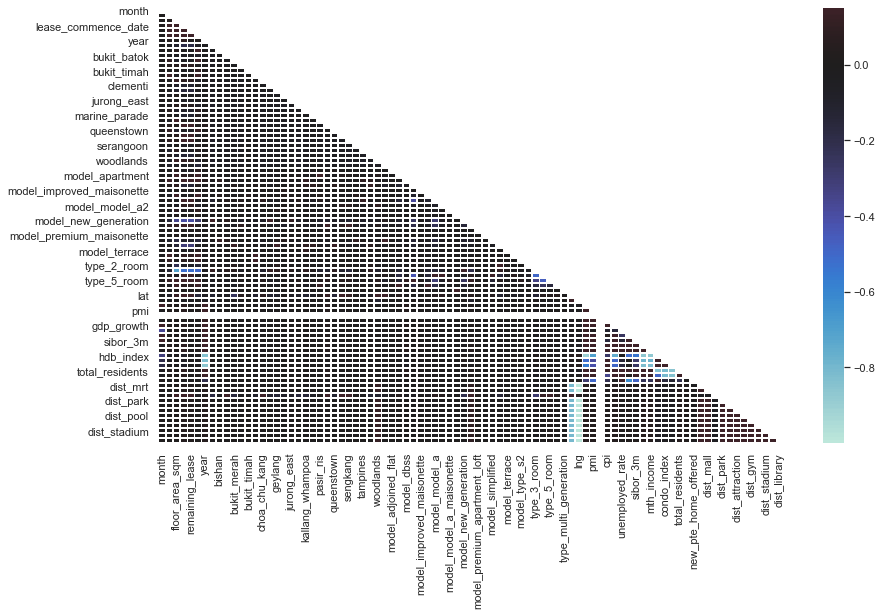

In [11]:
sns.set(style="white")
        
corr = hdb_df.corr()
fig,ax = plt.subplots(figsize=(14,8))

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corr,mask=mask,cbar=True,linewidths=0.5,square=False,vmax=.15, center=0)